In [2]:
from astrodendro import Dendrogram
# d = Dendrogram.compute(array)

In [1]:
# For plots
import matplotlib.pyplot as plt

from astropy.wcs import WCS

import numpy as np

from astropy.coordinates import SkyCoord
import astropy.units as u

import os
import sys
from astropy.io import fits

# Get the current working directory
curr_folder = os.getcwd()

# Find the index of 'notebooks' in the current path
notebooks_index = curr_folder.rfind('notebooks')

# Check if 'notebooks' is found in the path
if notebooks_index != -1:
    # Set the directory to the parent of 'notebooks'
    src_path = os.path.dirname(curr_folder[:notebooks_index])
    os.chdir(src_path)  # Change the current working directory to the source path
    sys.path.insert(0, src_path)  # Insert the source path into sys.path for module imports
    
# Lombardi et al
# the catalogue name in VizieR
CATALOGUE_LOMBARDI = "J/A+A/566/A45"

CATALOGUE_MEGEATH = "J/AJ/144/192"

Filename: c:\Users\User\Desktop\MA_Astro\Master Thesis\Lombardi\planck_herschel.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (3444, 2492, 7)   float32   


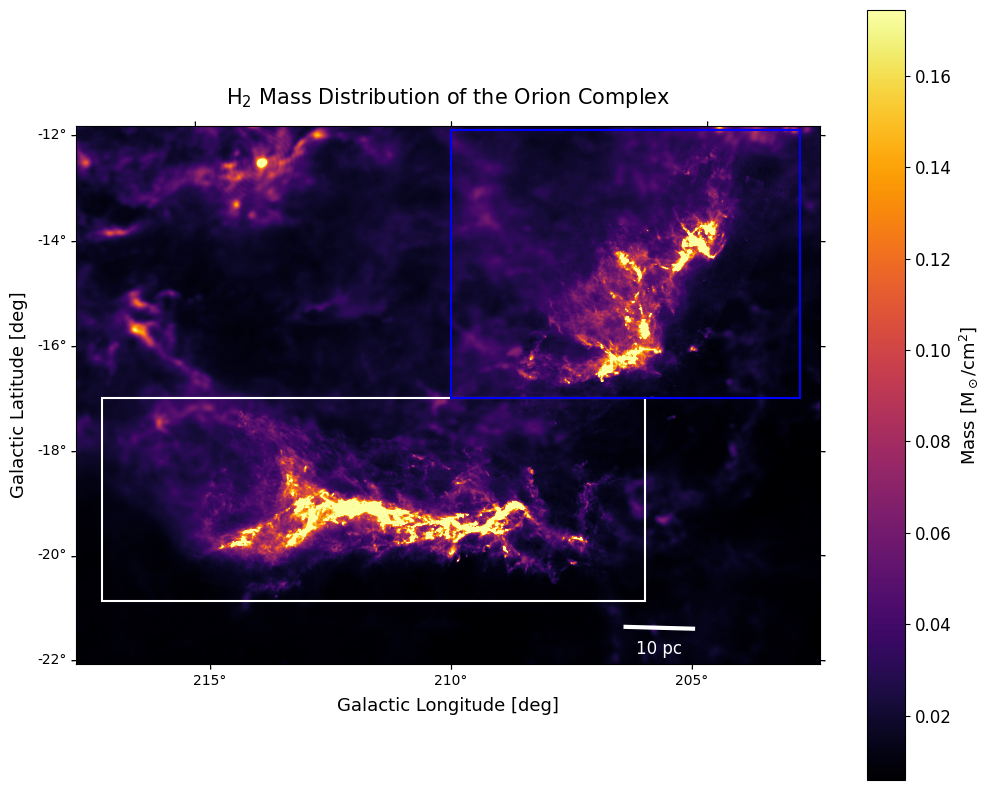

235938.58566051646


In [3]:
import matplotlib.patches as patches

def read_fits(filepath, print_header):
    # Check if the FITS file exists
    if not os.path.isfile(filepath):
        print(f"File not found: {filepath}")
    else:
        try:
            # Open the FITS file
            with fits.open(filepath) as hdul:
                # Print a summary of the HDUs (Header Data Units)
                hdul.info()

                # Access the primary HDU data (usually image data)
                primary_hdu = hdul[0].data
                
                # Access the header of the primary HDU
                header = hdul[0].header
                
                if print_header:
                    print("Header Information (without blank spaces):")
                    print("-" * 60)  # Separator line
                    for key in header.keys():
                        value = header[key]
                        comment = header.comments[key]
                        # Remove extra spaces from key, value, and comment
                        clean_key = key.strip()
                        clean_value = str(value).strip()
                        clean_comment = comment.strip()
                        print(f"{clean_key}={clean_value}#{clean_comment}")  # Format output without spaces

        except Exception as e:
            print(f"An error occurred while opening the FITS file: {e}")
    
    return primary_hdu, header

# Construct the path to the FITS file
planck_herschel_fits_file = os.path.join(curr_folder, "Lombardi", "planck_herschel.fits.gz")
maps_fits_file = os.path.join(curr_folder, "Lombardi", "maps.fits.gz")

hdu_herschel_fits_data, hdu_herschel_fits_header = read_fits(planck_herschel_fits_file, print_header=False)

# Constructt WCS and image data
wcs = WCS(hdu_herschel_fits_header)

image_data = hdu_herschel_fits_data[0]

# Replace NaNs and Infs with some valid value, e.g., zero or the median
tau = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

# Step 1: Define constants
# TO-DO: differentiate between Orion A and B 

# Orion A: 206 ≤ l ≤ 217, −21 ≤ b ≤ −17
# Orion B: 203 ≤ l ≤ 210, −17 ≤ b ≤ −12

# Step 3: Apply the formula to calculate A_k (Lomabrdi et al)
l_min_A, l_max_A = 206, 217
b_min_A, b_max_A = -21, -17

min_coord_A = SkyCoord(l_min_A, b_min_A, frame='galactic', unit=u.deg)
max_coord_A = SkyCoord(l_max_A, b_max_A, frame='galactic', unit=u.deg)

min_pixel_A = wcs[:][:][0].world_to_pixel(min_coord_A)
max_pixel_A = wcs[:][:][0].world_to_pixel(max_coord_A)

gamma_orion_A = 2640  # mag
delta_orion_A = 0.012  # mag, Offset for Orion A

A_k = gamma_orion_A * tau + delta_orion_A

A_k[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] = gamma_orion_A * tau[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] + delta_orion_A

l_min_B, l_max_B = 203, 210
b_min_B, b_max_B = -17, -12

min_coord_B = SkyCoord(l_min_B, b_min_B, frame='galactic', unit=u.deg)
max_coord_B = SkyCoord(l_max_B, b_max_B, frame='galactic', unit=u.deg)

min_pixel_B = wcs[:][:][0].world_to_pixel(min_coord_B)
max_pixel_B = wcs[:][:][0].world_to_pixel(max_coord_B)

gamma_orion_B = 3460  # mag
delta_orion_B = -0.001  # mag, Offset for Orion B

A_k[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] = gamma_orion_B * tau[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] + delta_orion_B

# A_k to A_V
A_V = A_k/0.112

# N(H2)
N_H2 = 0.93e21 * np.array(A_V , dtype=np.float64)

pixel_scale = 0.00417
distance = 420
radians = 180/np.pi #conversion factor: rad in deg
rad_per_px = pixel_scale/radians
pc_per_px = np.sin(rad_per_px)*distance
pc2_per_px = pc_per_px**2
cm_per_pc = 3.086*10**18
cm2_per_px = pc2_per_px * (cm_per_pc ** 2) 

D = 412

m_p = 1.67e-27 # mass of proton (kg)

M_H2 = np.array(N_H2, dtype=np.float64)*2.8*m_p/(1.98e30)

# M_H2 = M_H2*area # check here!
M_H2 = M_H2 * cm2_per_px

# Assuming M_H2_clean is already defined
M_H2_clean = np.nan_to_num(M_H2, nan=0.0, posinf=0.0, neginf=0.0)

# Masking out negative values
M_H2_clean_positive = np.where(M_H2_clean > 0, M_H2_clean, 0)

min_value = np.percentile(M_H2_clean_positive, 1)  # 2nd percentile
max_value = np.percentile(M_H2_clean_positive, 99)  # 98th percentile

plt.figure(figsize=(12, 10))
ax = plt.subplot(111, projection=wcs[0])

# Plot the map with imshow
sp = ax.imshow(M_H2_clean_positive, vmin=min_value, vmax=max_value, interpolation=None, origin='lower', cmap = 'inferno') # from the perceptually uniform sequential colormaps
ax.set_title("H$_2$ Mass Distribution of the Orion Complex", fontsize=15, pad=16)

# Add grid and colorbar
ax.set_xlabel("Galactic Longitude [deg]", fontsize=13)
ax.set_ylabel("Galactic Latitude [deg]", fontsize=13)

fig = plt.gcf()  # Get the current figure
cbar = fig.colorbar(sp)  # Label the colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Mass [M$_\odot$/cm$^2$]', fontsize=13)

# Define the rectangles for Orion A and B
# Rectangle for Orion A
width_A = max_pixel_A[0] - min_pixel_A[0]
height_A = max_pixel_A[1] - min_pixel_A[1]
rect_A = patches.Rectangle((min_pixel_A[0], min_pixel_A[1]), width_A, height_A, 
                           linewidth=1.5, edgecolor='white', facecolor='none')
ax.add_patch(rect_A)

# Rectangle for Orion B
width_B = max_pixel_B[0] - min_pixel_B[0]
height_B = max_pixel_B[1] - min_pixel_B[1]
rect_B = patches.Rectangle((min_pixel_B[0], min_pixel_B[1]), width_B, height_B, 
                           linewidth=1.5, edgecolor='blue', facecolor='none')
ax.add_patch(rect_B)

# scale_bar
# Compute the angle corresponding to 10 pc at the distance of the galactic center
gc_distance = 412 * u.pc
scalebar_length = 10 * u.pc
scalebar_angle = (scalebar_length / gc_distance).to(
    u.deg, equivalencies=u.dimensionless_angles()
)

# Define values with units
y = -21.5 * u.deg
xmin = 205 * u.deg
xmax = (205 * u.deg + scalebar_angle)

# Convert to degrees as floats
y_deg = y.to(u.deg).value
xmin_deg = xmin.to(u.deg).value
xmax_deg = xmax.to(u.deg).value

# Plot the line without units in hlines
ax.plot([xmin_deg, xmax_deg], [y_deg, y_deg], transform=ax.get_transform('world'), color='white', linewidth=3)
ax.text((xmin_deg + xmax_deg) / 2, y_deg - 0.5, "10 pc", transform=ax.get_transform('world'), color='white', ha='center', fontsize=12)

plt.show()
print(np.sum(M_H2_clean_positive))

In [4]:
M_H2_OA = M_H2_clean_positive[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])]
M_H2_OB = M_H2_clean_positive[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])]

d = Dendrogram.compute(M_H2_OA)

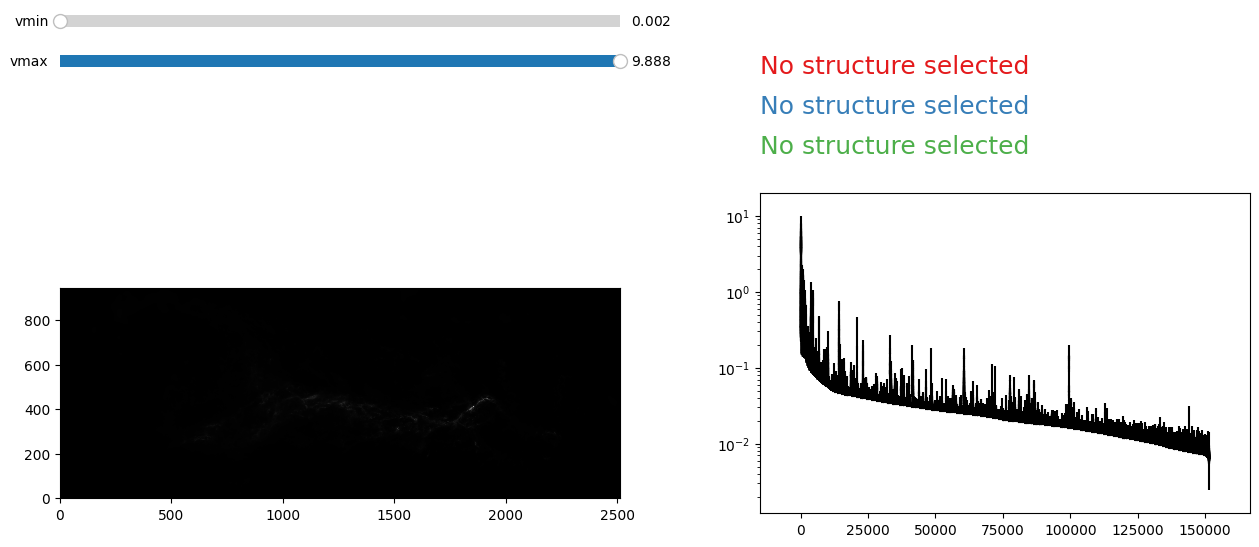

In [8]:
v = d.viewer()

In [10]:
v.show()